# Variational Autoencoders - Aula Prática

## Configurações

Importando módulos necessários

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torchsummary import summary

## Introdução

Variational Autoencoders (VAEs) são uma classe de modelos generativos que são treinados para representar dados de entrada em um espaço latente de baixa dimensão. Eles são baseados em redes neurais e são treinados usando métodos de inferência variacional. VAEs são uma extensão de autoencoders tradicionais, que são usados para aprender representações compactas de dados de entrada. A principal diferença entre VAEs e autoencoders tradicionais é que VAEs são treinados para aprender a distribuição de probabilidade dos dados de entrada, enquanto autoencoders tradicionais são treinados para aprender uma função de mapeamento determinística dos dados de entrada para um espaço latente.

Nessa aula prática, vamos implementar um Variational Autoencoder para reconstruir imagens do dataset MNIST.

## Dataset

Vamos começar carregando o dataset MNIST. O dataset é composto por imagens de dígitos escritos à mão, com dimensões 28x28 pixels.

In [2]:
mnist_path = '/pgeoprj2/ciag2024/dados'

In [3]:
"""
Como queremos que o autoencoder aprenda a reconstruir a imagem de entrada,
reformulamos o dataset MNIST para que ele retorne a mesma imagem como entrada e saída.
"""
class AutoencoderMNIST(torch.utils.data.Dataset):
    def __init__(self, root, train=True, transform=None, input_transform=None, target_transform=None, download=False, return_labels=False):
        self.dataset = datasets.MNIST(root=root, train=train, transform=transform, download=download)
        self.input_transform = input_transform
        self.target_transform = target_transform
        self.return_labels = return_labels

    def __getitem__(self, idx):
        x, label = self.dataset[idx]
        y = x.clone()

        if self.input_transform:
            x = self.input_transform(x)
        if self.target_transform:
            y = self.target_transform(y)

        return (x, y, label) if self.return_labels else (x, y)
    
    def start_return_labels(self):
        self.return_labels = True
    
    def stop_return_labels(self):
        self.return_labels = False

    def __len__(self):
        return len(self.dataset)

In [4]:
mnist_train_ds = AutoencoderMNIST(
    mnist_path,
    train=True,
    transform=transforms.ToTensor(),
    download=False,
    return_labels=True
)
mnist_test_ds = AutoencoderMNIST(
    mnist_path,
    train=False,
    transform=transforms.ToTensor()
)

print(
    "Tamanho do dataset de (treino, teste):", (len(mnist_train_ds), len(mnist_test_ds))
)

Tamanho do dataset de (treino, teste): (60000, 10000)


image shape: torch.Size([1, 28, 28])


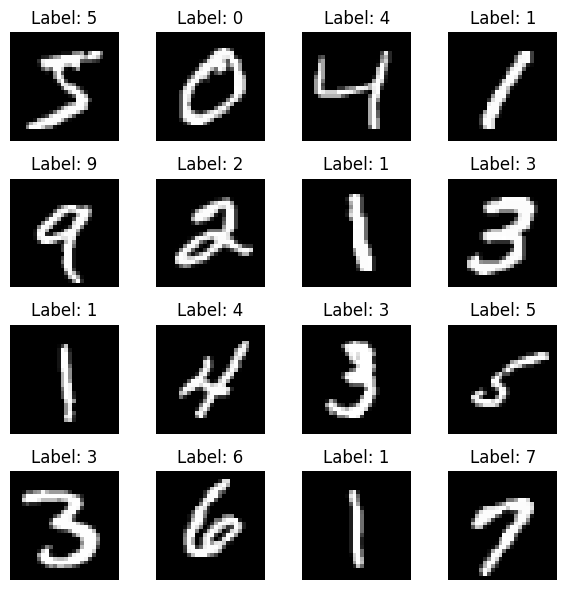

In [5]:
# Plot the first 16 images from the MNIST dataset
fig, axes = plt.subplots(4, 4, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    if i == 0:
        print(f"image shape: {mnist_train_ds[i][0].shape}")
    image, _, label = mnist_train_ds[i]
    ax.imshow(image.squeeze(), cmap="gray")  # Squeeze removes the channel dimension
    ax.set_title(f"Label: {label}")
    ax.axis("off")

plt.tight_layout()
plt.show()

## Modelo

Como já mencionado, um VAE é composto por duas partes principais: um encoder e um decoder. O encoder é uma rede neural que mapeia os dados de entrada para um espaço latente de baixa dimensão, enquanto o decoder é uma rede neural que mapeia os pontos no espaço latente de volta para o espaço de entrada.

O principal da arquitetura já vimos na aula sobre Autoencoders tradicionais, mas a diferença é que o encoder de um VAE mapeia os dados de entrada para uma distribuição de probabilidade no espaço latente, em vez de mapear os dados de entrada para um ponto específico no espaço latente, como podemos ver na imagem abaixo:

O encder vai transformar os dados em $ \mu $ e $ \sigma $, que são os parâmetros da distribuição normal que representa o espaço latente, seguindo a fórmula:

$$ 
z = \mu + \sigma \cdot \epsilon 
$$

com $ \epsilon $ sendo uma amostra de uma distribuição normal padrão.

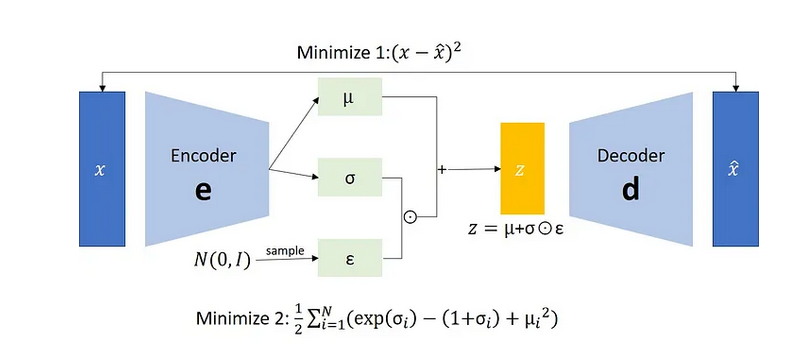

In [6]:
class VariationalConvolutionalEncoder(nn.Module):
    def __init__(self, latent_size=2, n_channels=3):
        super(VariationalConvolutionalEncoder, self).__init__()
        self.latent_size = latent_size

        # reduzimos o tamanho da imagem
        # considerando input (n_channels, 28, 28)
        self.conv_layers = nn.Sequential(
            nn.Conv2d(n_channels, 16, 3, padding=1),  # (16, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # (16, 14, 14)
            nn.Conv2d(16, 8, 3, padding=1),  # (8, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # (8, 7, 7)
            nn.Conv2d(8, 2, 3, padding=1),  # (2, 7, 7)
            nn.ReLU(),
        )

        # extraimos as features da imagem reduzida
        self.flatten = nn.Flatten()  # (2 * 7 * 7,) = (98,)

        # finalmente fazemos o encoding da nossa imagem em um vetor n dimensional
        self.z_log_sigma = nn.Linear(98, self.latent_size)
        self.z_mean = nn.Linear(98, self.latent_size)

    @property
    def device(self):
        return next(self.parameters()).device

    # função para amostrar a representação latente a partir da média e desvio padrão
    def sample(self, z_mean, z_log_sigma):
        epsilon = torch.normal(0, 0.1, z_mean.shape, device=self.device)
        return z_mean + torch.exp(z_log_sigma) * epsilon
    
    # função para calcular a divergência KL para a loss
    def kl_divergence(self):
        return -0.5 * torch.sum(1 + self.stdev - self.mean.pow(2) - self.stdev.exp())

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)

        # salvamos os valores de média e desvio padrão para serem usados na loss
        self.stdev = self.z_log_sigma(x)
        self.mean = self.z_mean(x)

        x = self.sample(self.mean, self.stdev)

        return x

In [7]:
# O decoder do VAE é o mesmo que o do AE
class ConvolutionalDecoder(nn.Module):
    def __init__(self, latent_size=2, n_channels=3):
        super(ConvolutionalDecoder, self).__init__()
        self.latent_size = latent_size

        # decodificamos a representação latente para uma imagem 7x7
        self.decoder = nn.Linear(self.latent_size, 98)
        self.unflatten = nn.Unflatten(1, (2, 7, 7)) # (2, 7, 7)

        # voltamos a imagem ao tamanho original
        self.conv_layers = nn.Sequential(
            nn.Conv2d(2, 8, 3, padding=1), # (8, 7, 7)
            nn.ReLU(),
            nn.Upsample(scale_factor=2), # (8, 14, 14)
            nn.Conv2d(8, 16, 3, padding=1), # (16, 14, 14)
            nn.ReLU(),
            nn.Upsample(scale_factor=2), # (16, 28, 28)
            nn.Conv2d(16, n_channels, 3, padding=1), # (n_channels, 28, 28)
            nn.Sigmoid(), # sigmoid na última camada para que o output esteja no intervalo [0, 1]
        )

    def forward(self, x):
        x = self.decoder(x)
        x = self.unflatten(x)
        x = self.conv_layers(x)
        return x

In [8]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_size=2, n_channels=3):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalConvolutionalEncoder(latent_size, n_channels)
        self.decoder = ConvolutionalDecoder(latent_size, n_channels)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
vae = VariationalAutoencoder(latent_size=2, n_channels=1)
print(vae)

VariationalAutoencoder(
  (encoder): VariationalConvolutionalEncoder(
    (conv_layers): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(8, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (z_log_sigma): Linear(in_features=98, out_features=2, bias=True)
    (z_mean): Linear(in_features=98, out_features=2, bias=True)
  )
  (decoder): ConvolutionalDecoder(
    (decoder): Linear(in_features=2, out_features=98, bias=True)
    (unflatten): Unflatten(dim=1, unflattened_size=(2, 7, 7))
    (conv_layers): Sequential(
      (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), pad

## Treinando o modelo

Vamos treinar o modelo para reconstruir imagens do dataset MNIST. O modelo será treinado por 20 épocas, com batch size 128 e otimizador Adam.

In [10]:
def loss_to_string(loss, prefix):
    return ' '.join([f'{prefix}_{l}: {loss[l]:.4f}' for l in loss])

def train(model, optimizer, loss_fn, train_loader, val_loader=None, device='cpu', epochs=32):
    model.to(device)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_losses = {'loss': 0.0}

        for i, (inputs, targets) in (pbar := tqdm(enumerate(train_loader), total=len(train_loader), unit='batch')):
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the gradient buffers
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            # A loss é computada contra o input pois queremos reconstruir a imagem de entrada
            rec_loss = loss_fn(outputs, targets)
            rec_loss /= inputs.size(0)
            train_losses['rec_loss'] = train_losses.get('rec_loss', 0.0) + rec_loss.item()

            # Adicionamos a divergência KL à loss
            kl_loss = model.encoder.kl_divergence()
            kl_loss /= inputs.size(0)
            train_losses['kl_loss'] = train_losses.get('kl_loss', 0.0) + kl_loss.item()

            loss = rec_loss + kl_loss

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_losses['loss'] += loss.item()
            pbar.set_description(f"Epoch {epoch + 1}/{epochs} - Loss: {train_losses['loss']/(i+1):.4f}")

        for l in train_losses:
            train_losses[l] /= len(train_loader)

        # Validation phase
        if val_loader is not None:
            model.eval()
            val_losses = {'loss': 0.0}

            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)

                    outputs = model(inputs)
                    rec_loss = loss_fn(outputs, targets)
                    rec_loss /= inputs.size(0)
                    val_losses['rec_loss'] = val_losses.get('rec_loss', 0.0) + rec_loss.item()

                    kl_loss = model.encoder.kl_divergence()
                    kl_loss /= inputs.size(0)
                    val_losses['kl_loss'] = val_losses.get('kl_loss', 0.0) + kl_loss.item()

                    loss = rec_loss + kl_loss

                    val_losses['loss'] += loss.item()

            for l in val_losses:
                val_losses[l] /= len(val_loader)

            print(f"Epoch {epoch + 1}/{epochs}: {loss_to_string(train_losses, 'train')} | {loss_to_string(val_losses, 'val')}")
        else:
            print(f"Epoch {epoch + 1}/{epochs}: {loss_to_string(train_losses, 'train')}")

In [11]:
vae = VariationalAutoencoder(latent_size=2, n_channels=1)

In [12]:
mnist_train_ds.stop_return_labels()
mnist_test_ds.stop_return_labels()
train_dl = DataLoader(mnist_train_ds, batch_size=128, shuffle=True)
test_dl = DataLoader(mnist_test_ds, batch_size=128)

In [13]:
epochs = 20

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(vae, optimizer, criterion, train_dl, test_dl, device=device, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/20: train_loss: 59.5680 train_rec_loss: 58.8594 train_kl_loss: 0.7086 | val_loss: 45.7039 val_rec_loss: 45.1597 val_kl_loss: 0.5442


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/20: train_loss: 44.6365 train_rec_loss: 44.1428 train_kl_loss: 0.4937 | val_loss: 43.8294 val_rec_loss: 43.3673 val_kl_loss: 0.4622


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/20: train_loss: 43.3791 train_rec_loss: 42.9125 train_kl_loss: 0.4666 | val_loss: 42.9582 val_rec_loss: 42.5162 val_kl_loss: 0.4419


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/20: train_loss: 42.6095 train_rec_loss: 42.1491 train_kl_loss: 0.4604 | val_loss: 42.2150 val_rec_loss: 41.7388 val_kl_loss: 0.4762


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/20: train_loss: 41.6687 train_rec_loss: 41.1898 train_kl_loss: 0.4789 | val_loss: 40.8750 val_rec_loss: 40.3784 val_kl_loss: 0.4966


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/20: train_loss: 40.7115 train_rec_loss: 40.2104 train_kl_loss: 0.5011 | val_loss: 40.2074 val_rec_loss: 39.7083 val_kl_loss: 0.4991


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/20: train_loss: 40.1879 train_rec_loss: 39.6721 train_kl_loss: 0.5158 | val_loss: 39.8389 val_rec_loss: 39.3282 val_kl_loss: 0.5107


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/20: train_loss: 39.8302 train_rec_loss: 39.3010 train_kl_loss: 0.5292 | val_loss: 39.5438 val_rec_loss: 38.9898 val_kl_loss: 0.5540


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/20: train_loss: 39.5267 train_rec_loss: 38.9882 train_kl_loss: 0.5385 | val_loss: 39.2322 val_rec_loss: 38.6292 val_kl_loss: 0.6030


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/20: train_loss: 39.2568 train_rec_loss: 38.7047 train_kl_loss: 0.5521 | val_loss: 38.9824 val_rec_loss: 38.4386 val_kl_loss: 0.5438


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/20: train_loss: 38.9967 train_rec_loss: 38.4342 train_kl_loss: 0.5625 | val_loss: 38.7976 val_rec_loss: 38.2431 val_kl_loss: 0.5545


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/20: train_loss: 38.7425 train_rec_loss: 38.1666 train_kl_loss: 0.5758 | val_loss: 38.5274 val_rec_loss: 37.9622 val_kl_loss: 0.5652


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/20: train_loss: 38.5146 train_rec_loss: 37.9290 train_kl_loss: 0.5856 | val_loss: 38.3521 val_rec_loss: 37.7828 val_kl_loss: 0.5693


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/20: train_loss: 38.3303 train_rec_loss: 37.7299 train_kl_loss: 0.6004 | val_loss: 38.1338 val_rec_loss: 37.5360 val_kl_loss: 0.5978


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/20: train_loss: 38.1663 train_rec_loss: 37.5577 train_kl_loss: 0.6085 | val_loss: 37.9764 val_rec_loss: 37.3678 val_kl_loss: 0.6086


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 16/20: train_loss: 38.0126 train_rec_loss: 37.3997 train_kl_loss: 0.6129 | val_loss: 38.1496 val_rec_loss: 37.5394 val_kl_loss: 0.6102


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 17/20: train_loss: 37.8621 train_rec_loss: 37.2380 train_kl_loss: 0.6241 | val_loss: 37.7769 val_rec_loss: 37.1640 val_kl_loss: 0.6129


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 18/20: train_loss: 37.7575 train_rec_loss: 37.1270 train_kl_loss: 0.6305 | val_loss: 37.6795 val_rec_loss: 37.0554 val_kl_loss: 0.6242


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 19/20: train_loss: 37.6266 train_rec_loss: 36.9953 train_kl_loss: 0.6313 | val_loss: 37.5535 val_rec_loss: 36.9120 val_kl_loss: 0.6415


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 20/20: train_loss: 37.5506 train_rec_loss: 36.9130 train_kl_loss: 0.6376 | val_loss: 37.5448 val_rec_loss: 36.8626 val_kl_loss: 0.6822


## Analisando os resultados

Nessa etapa, vamos analisar os resultados obtidos pelo autoencoder. Vamos visualizar as imagens de entrada e as imagens reconstruídas pelo autoencoder. Além disso, vamos visualizar a representação dos dados no espaço latente.

Loss for image 1: 25.57036018371582
Loss for image 2: 73.28916931152344
Loss for image 3: 6.158267021179199
Loss for image 4: 28.935340881347656
Loss for image 5: 33.69880294799805
Loss for image 6: 5.633626937866211
Loss for image 7: 46.377891540527344
Loss for image 8: 41.579811096191406


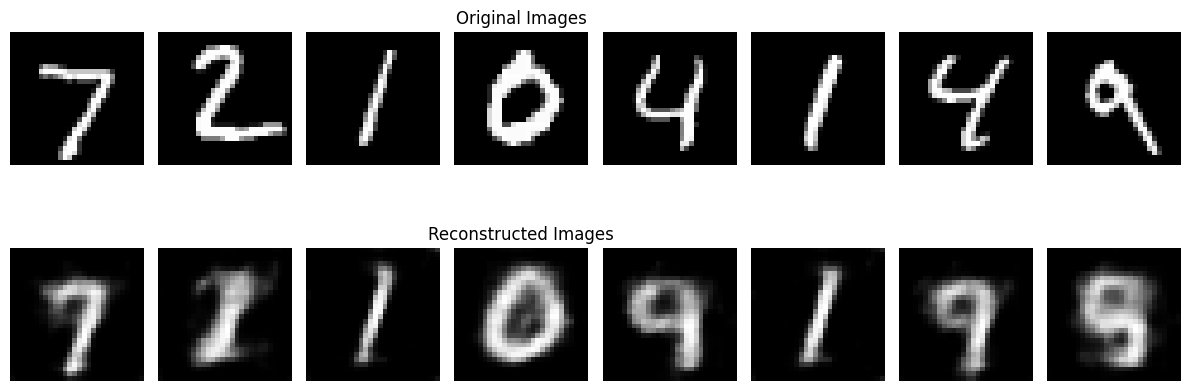

In [14]:
# Get some images from the test dataset
data_iter = iter(test_dl)
images, _ = next(data_iter)

# Move images to the device
images = images.to(device)

# Pass the images through the autoencoder
vae.eval()
with torch.no_grad():
    reconstructions = vae(images)

# Plot the original and reconstructed images
fig, axes = plt.subplots(2, 8, figsize=(12, 5))

for i in range(8):
    ax = axes[0, i]
    ax.imshow(images[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Original Images')

    # Reconstructed images
    ax = axes[1, i]
    ax.imshow(reconstructions[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Reconstructed Images')

    loss = criterion(reconstructions[i], images[i])
    print(f"Loss for image {i+1}: {loss.item()}")

plt.tight_layout()
plt.show()

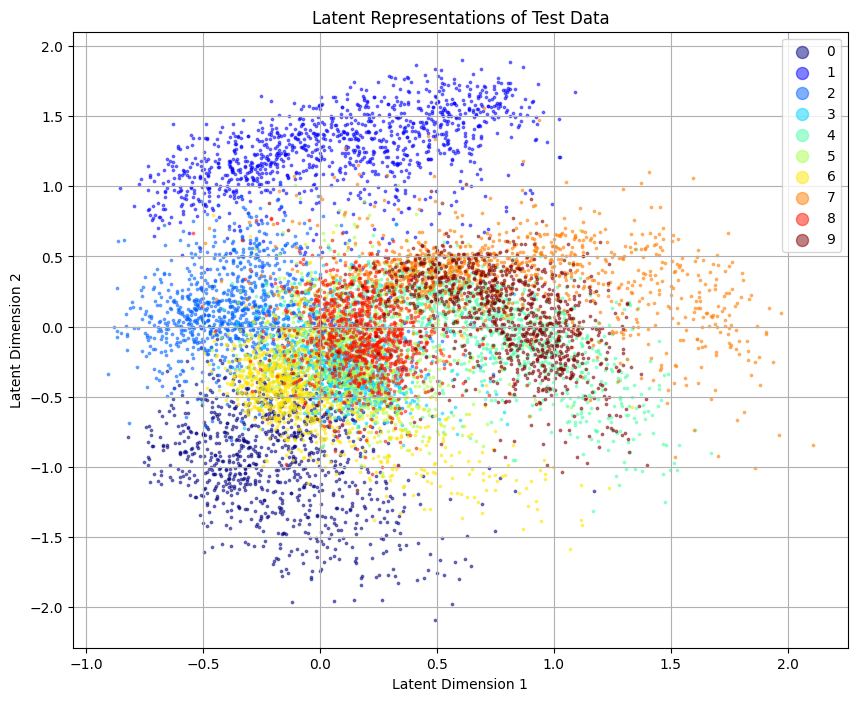

In [15]:
# Get the latent representations for all test data
latent_representations = []
labels_agg = []
digits = list(range(10))

mnist_test_ds.start_return_labels()
test_dl_with_labels = DataLoader(mnist_test_ds, batch_size=128)

vae.eval()
with torch.no_grad():
    for images, _, labels in test_dl_with_labels:
        images = images.to(device)
        latent_vectors = vae.encoder(images)
        latent_representations.append(latent_vectors.cpu().numpy())
        labels_agg.append(labels.numpy())

# Concatenate all latent representations
latent_representations = np.concatenate(latent_representations, axis=0)
labels_agg = np.concatenate(labels_agg, axis=0)

# Plot the latent representations
plt.figure(figsize=(10, 8))
cmap = plt.get_cmap('jet', 10)
for d in digits:
    indices = np.where(labels_agg == d)
    plt.scatter(
        latent_representations[indices, 0],
        latent_representations[indices, 1],
        s=3,
        label=f"{d}",
        c=[cmap(d)],
        alpha=0.5,
    )
# add the labels mapping
plt.legend(markerscale=5)
plt.title('Latent Representations of Test Data')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True)
plt.show()

É interessante observar na distribuição dos dados no em comparação com com o observado no resultado do Autoencoder tradicional é que o Autoencoder Variacional distribui os dados no espaço latente tentando seguir uma distribuição normal padrão.

# Exercícios

## Exercício 1

Teste o autoencoder variacional com mais dimensionalidades no espaço latente. Tente com 5, 20 e 50 dimensões. Compare os resultados obtidos.

<details>
<summary>Dica:</summary>

Para visualizar a representação dos dados no espaço latente, utilize um [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) para reduzir a dimensionalidade dos dados para 2 dimensões.

</details>

In [16]:
vae2 = VariationalAutoencoder(latent_size=2, n_channels=1)
vae5 = VariationalAutoencoder(latent_size=5, n_channels=1)
vae20 = VariationalAutoencoder(latent_size=20, n_channels=1)
vae50 = VariationalAutoencoder(latent_size=50, n_channels=1)

In [17]:
mnist_train_ds.stop_return_labels()
mnist_test_ds.stop_return_labels()
train_dl = DataLoader(mnist_train_ds, batch_size=128, shuffle=True)
test_dl = DataLoader(mnist_test_ds, batch_size=128)

In [18]:
epochs = 20

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(vae2.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(vae2, optimizer, criterion, train_dl, test_dl, device=device, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/20: train_loss: 57.8411 train_rec_loss: 57.1905 train_kl_loss: 0.6506 | val_loss: 44.5156 val_rec_loss: 43.8686 val_kl_loss: 0.6470


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/20: train_loss: 43.5338 train_rec_loss: 42.8659 train_kl_loss: 0.6679 | val_loss: 42.6310 val_rec_loss: 41.9873 val_kl_loss: 0.6437


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/20: train_loss: 42.3925 train_rec_loss: 41.7525 train_kl_loss: 0.6400 | val_loss: 41.8832 val_rec_loss: 41.2491 val_kl_loss: 0.6341


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/20: train_loss: 41.8095 train_rec_loss: 41.1833 train_kl_loss: 0.6263 | val_loss: 41.4459 val_rec_loss: 40.8129 val_kl_loss: 0.6330


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/20: train_loss: 41.3672 train_rec_loss: 40.7450 train_kl_loss: 0.6222 | val_loss: 41.0256 val_rec_loss: 40.4359 val_kl_loss: 0.5897


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/20: train_loss: 40.9689 train_rec_loss: 40.3478 train_kl_loss: 0.6211 | val_loss: 40.6075 val_rec_loss: 39.9847 val_kl_loss: 0.6228


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/20: train_loss: 40.5764 train_rec_loss: 39.9561 train_kl_loss: 0.6202 | val_loss: 40.1169 val_rec_loss: 39.4932 val_kl_loss: 0.6237


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/20: train_loss: 40.2324 train_rec_loss: 39.6080 train_kl_loss: 0.6244 | val_loss: 39.7897 val_rec_loss: 39.1812 val_kl_loss: 0.6085


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/20: train_loss: 39.8904 train_rec_loss: 39.2609 train_kl_loss: 0.6295 | val_loss: 39.6148 val_rec_loss: 38.9573 val_kl_loss: 0.6575


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/20: train_loss: 39.6361 train_rec_loss: 38.9992 train_kl_loss: 0.6369 | val_loss: 39.3298 val_rec_loss: 38.7093 val_kl_loss: 0.6205


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/20: train_loss: 39.3971 train_rec_loss: 38.7576 train_kl_loss: 0.6396 | val_loss: 39.0492 val_rec_loss: 38.4240 val_kl_loss: 0.6252


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/20: train_loss: 39.2133 train_rec_loss: 38.5716 train_kl_loss: 0.6417 | val_loss: 38.8066 val_rec_loss: 38.0988 val_kl_loss: 0.7079


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/20: train_loss: 39.0550 train_rec_loss: 38.4122 train_kl_loss: 0.6429 | val_loss: 38.7036 val_rec_loss: 38.0619 val_kl_loss: 0.6417


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/20: train_loss: 38.9042 train_rec_loss: 38.2586 train_kl_loss: 0.6456 | val_loss: 38.5994 val_rec_loss: 37.9353 val_kl_loss: 0.6641


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/20: train_loss: 38.8137 train_rec_loss: 38.1670 train_kl_loss: 0.6467 | val_loss: 38.5275 val_rec_loss: 37.8827 val_kl_loss: 0.6448


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 16/20: train_loss: 38.6971 train_rec_loss: 38.0529 train_kl_loss: 0.6442 | val_loss: 38.3924 val_rec_loss: 37.7317 val_kl_loss: 0.6607


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 17/20: train_loss: 38.5911 train_rec_loss: 37.9363 train_kl_loss: 0.6548 | val_loss: 38.2532 val_rec_loss: 37.5724 val_kl_loss: 0.6808


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 18/20: train_loss: 38.5109 train_rec_loss: 37.8590 train_kl_loss: 0.6519 | val_loss: 38.1618 val_rec_loss: 37.4987 val_kl_loss: 0.6631


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 19/20: train_loss: 38.4003 train_rec_loss: 37.7482 train_kl_loss: 0.6521 | val_loss: 38.1301 val_rec_loss: 37.4592 val_kl_loss: 0.6709


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 20/20: train_loss: 38.3213 train_rec_loss: 37.6701 train_kl_loss: 0.6512 | val_loss: 38.0493 val_rec_loss: 37.3977 val_kl_loss: 0.6516


In [19]:
epochs = 20

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(vae5.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(vae5, optimizer, criterion, train_dl, test_dl, device=device, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/20: train_loss: 58.7698 train_rec_loss: 57.4664 train_kl_loss: 1.3034 | val_loss: 39.4965 val_rec_loss: 38.4063 val_kl_loss: 1.0902


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/20: train_loss: 36.1780 train_rec_loss: 35.0529 train_kl_loss: 1.1251 | val_loss: 33.9746 val_rec_loss: 32.8617 val_kl_loss: 1.1129


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/20: train_loss: 33.1747 train_rec_loss: 32.0327 train_kl_loss: 1.1420 | val_loss: 32.0909 val_rec_loss: 30.9941 val_kl_loss: 1.0969


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/20: train_loss: 31.6475 train_rec_loss: 30.5120 train_kl_loss: 1.1354 | val_loss: 30.8823 val_rec_loss: 29.7398 val_kl_loss: 1.1426


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/20: train_loss: 30.5367 train_rec_loss: 29.4088 train_kl_loss: 1.1279 | val_loss: 29.8767 val_rec_loss: 28.7435 val_kl_loss: 1.1333


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/20: train_loss: 29.7203 train_rec_loss: 28.6081 train_kl_loss: 1.1123 | val_loss: 29.2274 val_rec_loss: 28.1827 val_kl_loss: 1.0447


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/20: train_loss: 29.0963 train_rec_loss: 27.9854 train_kl_loss: 1.1109 | val_loss: 28.6700 val_rec_loss: 27.5703 val_kl_loss: 1.0997


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/20: train_loss: 28.6068 train_rec_loss: 27.4980 train_kl_loss: 1.1089 | val_loss: 28.2091 val_rec_loss: 27.1257 val_kl_loss: 1.0834


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/20: train_loss: 28.2191 train_rec_loss: 27.1130 train_kl_loss: 1.1061 | val_loss: 27.9333 val_rec_loss: 26.8909 val_kl_loss: 1.0424


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/20: train_loss: 27.9076 train_rec_loss: 26.8036 train_kl_loss: 1.1040 | val_loss: 27.6200 val_rec_loss: 26.5151 val_kl_loss: 1.1048


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/20: train_loss: 27.6379 train_rec_loss: 26.5300 train_kl_loss: 1.1079 | val_loss: 27.4138 val_rec_loss: 26.2816 val_kl_loss: 1.1323


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/20: train_loss: 27.4255 train_rec_loss: 26.3138 train_kl_loss: 1.1116 | val_loss: 27.2701 val_rec_loss: 26.1657 val_kl_loss: 1.1043


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/20: train_loss: 27.2494 train_rec_loss: 26.1320 train_kl_loss: 1.1175 | val_loss: 27.1087 val_rec_loss: 26.0165 val_kl_loss: 1.0922


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/20: train_loss: 27.0719 train_rec_loss: 25.9539 train_kl_loss: 1.1180 | val_loss: 26.9368 val_rec_loss: 25.8678 val_kl_loss: 1.0690


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/20: train_loss: 26.9475 train_rec_loss: 25.8277 train_kl_loss: 1.1198 | val_loss: 26.6956 val_rec_loss: 25.5804 val_kl_loss: 1.1152


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 16/20: train_loss: 26.8425 train_rec_loss: 25.7203 train_kl_loss: 1.1222 | val_loss: 26.7376 val_rec_loss: 25.6448 val_kl_loss: 1.0928


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 17/20: train_loss: 26.7487 train_rec_loss: 25.6252 train_kl_loss: 1.1235 | val_loss: 26.5338 val_rec_loss: 25.4040 val_kl_loss: 1.1299


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 18/20: train_loss: 26.6554 train_rec_loss: 25.5314 train_kl_loss: 1.1240 | val_loss: 26.4531 val_rec_loss: 25.3466 val_kl_loss: 1.1065


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 19/20: train_loss: 26.5722 train_rec_loss: 25.4434 train_kl_loss: 1.1289 | val_loss: 26.4202 val_rec_loss: 25.3091 val_kl_loss: 1.1111


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 20/20: train_loss: 26.5216 train_rec_loss: 25.3933 train_kl_loss: 1.1282 | val_loss: 26.3705 val_rec_loss: 25.2694 val_kl_loss: 1.1011


In [20]:
epochs = 20

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(vae20.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(vae20, optimizer, criterion, train_dl, test_dl, device=device, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/20: train_loss: 47.4482 train_rec_loss: 45.6504 train_kl_loss: 1.7978 | val_loss: 23.7306 val_rec_loss: 21.7188 val_kl_loss: 2.0118


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/20: train_loss: 20.9895 train_rec_loss: 18.9157 train_kl_loss: 2.0737 | val_loss: 18.4610 val_rec_loss: 16.3406 val_kl_loss: 2.1203


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/20: train_loss: 17.7948 train_rec_loss: 15.6805 train_kl_loss: 2.1143 | val_loss: 16.5987 val_rec_loss: 14.4778 val_kl_loss: 2.1209


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/20: train_loss: 16.4317 train_rec_loss: 14.3293 train_kl_loss: 2.1024 | val_loss: 15.5859 val_rec_loss: 13.5371 val_kl_loss: 2.0488


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/20: train_loss: 15.6557 train_rec_loss: 13.5571 train_kl_loss: 2.0986 | val_loss: 15.0000 val_rec_loss: 12.9058 val_kl_loss: 2.0941


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/20: train_loss: 15.0835 train_rec_loss: 12.9855 train_kl_loss: 2.0980 | val_loss: 14.4623 val_rec_loss: 12.3727 val_kl_loss: 2.0896


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/20: train_loss: 14.6331 train_rec_loss: 12.5391 train_kl_loss: 2.0939 | val_loss: 14.0731 val_rec_loss: 11.9839 val_kl_loss: 2.0892


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/20: train_loss: 14.2843 train_rec_loss: 12.1910 train_kl_loss: 2.0934 | val_loss: 13.7540 val_rec_loss: 11.6877 val_kl_loss: 2.0663


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/20: train_loss: 14.0085 train_rec_loss: 11.9094 train_kl_loss: 2.0991 | val_loss: 13.5254 val_rec_loss: 11.3789 val_kl_loss: 2.1465


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/20: train_loss: 13.7811 train_rec_loss: 11.6778 train_kl_loss: 2.1033 | val_loss: 13.3563 val_rec_loss: 11.1928 val_kl_loss: 2.1635


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/20: train_loss: 13.6021 train_rec_loss: 11.4918 train_kl_loss: 2.1103 | val_loss: 13.2472 val_rec_loss: 11.1076 val_kl_loss: 2.1396


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/20: train_loss: 13.4368 train_rec_loss: 11.3203 train_kl_loss: 2.1166 | val_loss: 13.0105 val_rec_loss: 10.8515 val_kl_loss: 2.1589


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/20: train_loss: 13.2938 train_rec_loss: 11.1721 train_kl_loss: 2.1217 | val_loss: 12.9401 val_rec_loss: 10.8333 val_kl_loss: 2.1068


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/20: train_loss: 13.2081 train_rec_loss: 11.0727 train_kl_loss: 2.1354 | val_loss: 12.8369 val_rec_loss: 10.7273 val_kl_loss: 2.1095


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/20: train_loss: 13.0845 train_rec_loss: 10.9492 train_kl_loss: 2.1354 | val_loss: 12.7152 val_rec_loss: 10.5798 val_kl_loss: 2.1354


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 16/20: train_loss: 12.9859 train_rec_loss: 10.8412 train_kl_loss: 2.1447 | val_loss: 12.5956 val_rec_loss: 10.4664 val_kl_loss: 2.1292


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 17/20: train_loss: 12.9107 train_rec_loss: 10.7639 train_kl_loss: 2.1468 | val_loss: 12.7111 val_rec_loss: 10.6003 val_kl_loss: 2.1108


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 18/20: train_loss: 12.8327 train_rec_loss: 10.6832 train_kl_loss: 2.1494 | val_loss: 12.4626 val_rec_loss: 10.3540 val_kl_loss: 2.1086


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 19/20: train_loss: 12.7389 train_rec_loss: 10.5855 train_kl_loss: 2.1534 | val_loss: 12.4022 val_rec_loss: 10.2743 val_kl_loss: 2.1279


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 20/20: train_loss: 12.6879 train_rec_loss: 10.5327 train_kl_loss: 2.1552 | val_loss: 12.3568 val_rec_loss: 10.1682 val_kl_loss: 2.1886


In [21]:
epochs = 20

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(vae50.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(vae50, optimizer, criterion, train_dl, test_dl, device=device, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/20: train_loss: 42.9546 train_rec_loss: 41.1249 train_kl_loss: 1.8296 | val_loss: 20.1184 val_rec_loss: 17.7425 val_kl_loss: 2.3759


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/20: train_loss: 17.5249 train_rec_loss: 15.0272 train_kl_loss: 2.4977 | val_loss: 15.2966 val_rec_loss: 12.7832 val_kl_loss: 2.5134


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/20: train_loss: 14.6401 train_rec_loss: 12.0963 train_kl_loss: 2.5438 | val_loss: 13.4785 val_rec_loss: 10.9168 val_kl_loss: 2.5617


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/20: train_loss: 13.1535 train_rec_loss: 10.6335 train_kl_loss: 2.5201 | val_loss: 12.3473 val_rec_loss: 9.8140 val_kl_loss: 2.5333


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/20: train_loss: 12.2551 train_rec_loss: 9.7543 train_kl_loss: 2.5008 | val_loss: 11.5757 val_rec_loss: 9.0303 val_kl_loss: 2.5454


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/20: train_loss: 11.6315 train_rec_loss: 9.1352 train_kl_loss: 2.4963 | val_loss: 11.0867 val_rec_loss: 8.6146 val_kl_loss: 2.4721


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/20: train_loss: 11.1654 train_rec_loss: 8.6665 train_kl_loss: 2.4989 | val_loss: 10.7238 val_rec_loss: 8.2129 val_kl_loss: 2.5109


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/20: train_loss: 10.7497 train_rec_loss: 8.2379 train_kl_loss: 2.5118 | val_loss: 10.3995 val_rec_loss: 7.9486 val_kl_loss: 2.4509


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/20: train_loss: 10.4166 train_rec_loss: 7.9008 train_kl_loss: 2.5158 | val_loss: 9.9883 val_rec_loss: 7.5040 val_kl_loss: 2.4843


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/20: train_loss: 10.1249 train_rec_loss: 7.5953 train_kl_loss: 2.5296 | val_loss: 9.8333 val_rec_loss: 7.3142 val_kl_loss: 2.5191


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/20: train_loss: 9.9182 train_rec_loss: 7.3799 train_kl_loss: 2.5383 | val_loss: 9.5708 val_rec_loss: 7.0034 val_kl_loss: 2.5674


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/20: train_loss: 9.7765 train_rec_loss: 7.2290 train_kl_loss: 2.5475 | val_loss: 9.4765 val_rec_loss: 6.9464 val_kl_loss: 2.5300


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/20: train_loss: 9.6279 train_rec_loss: 7.0779 train_kl_loss: 2.5500 | val_loss: 9.3684 val_rec_loss: 6.7800 val_kl_loss: 2.5884


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/20: train_loss: 9.5242 train_rec_loss: 6.9722 train_kl_loss: 2.5520 | val_loss: 9.2702 val_rec_loss: 6.7701 val_kl_loss: 2.5001


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/20: train_loss: 9.4089 train_rec_loss: 6.8560 train_kl_loss: 2.5529 | val_loss: 9.2500 val_rec_loss: 6.6972 val_kl_loss: 2.5528


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 16/20: train_loss: 9.3316 train_rec_loss: 6.7710 train_kl_loss: 2.5606 | val_loss: 9.0976 val_rec_loss: 6.5195 val_kl_loss: 2.5781


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 17/20: train_loss: 9.2497 train_rec_loss: 6.6884 train_kl_loss: 2.5613 | val_loss: 9.0504 val_rec_loss: 6.4578 val_kl_loss: 2.5926


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 18/20: train_loss: 9.1830 train_rec_loss: 6.6179 train_kl_loss: 2.5651 | val_loss: 8.9313 val_rec_loss: 6.3900 val_kl_loss: 2.5413


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 19/20: train_loss: 9.1010 train_rec_loss: 6.5371 train_kl_loss: 2.5639 | val_loss: 8.9364 val_rec_loss: 6.4068 val_kl_loss: 2.5296


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 20/20: train_loss: 9.0510 train_rec_loss: 6.4805 train_kl_loss: 2.5705 | val_loss: 8.8397 val_rec_loss: 6.2459 val_kl_loss: 2.5938


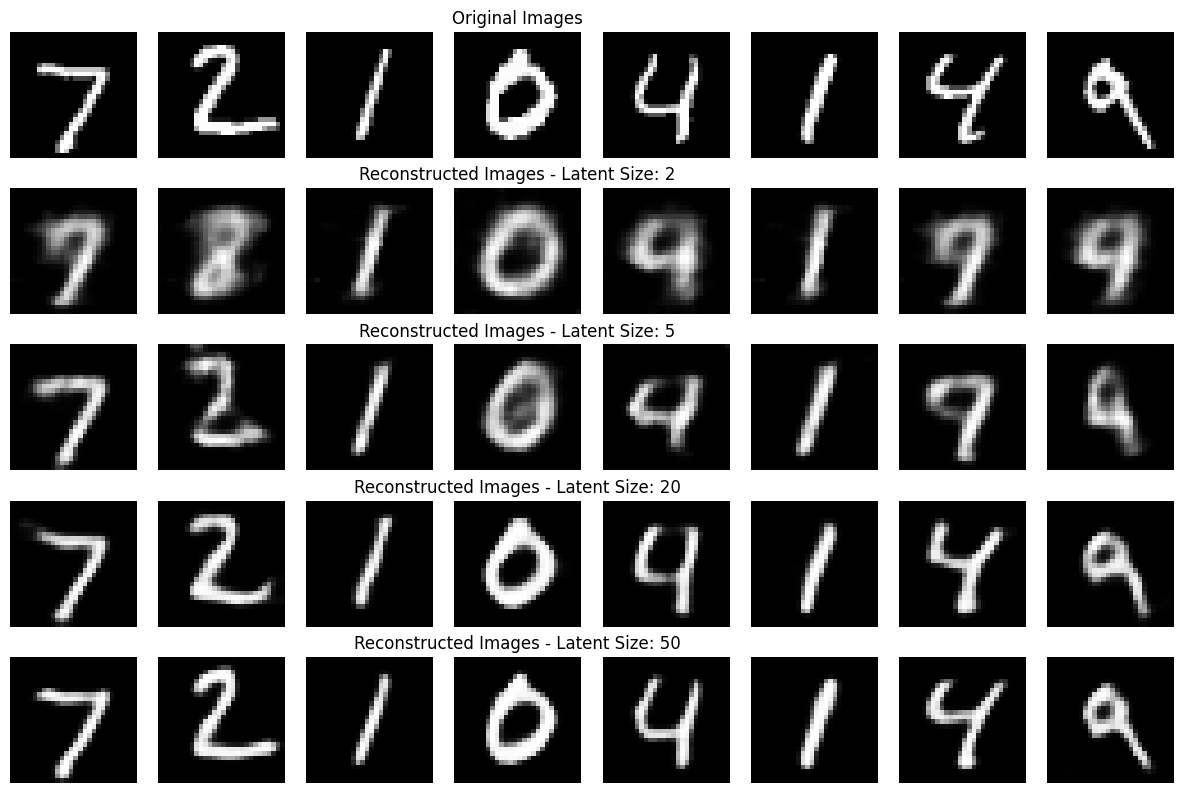

In [22]:
# Get some images from the test dataset
data_iter = iter(test_dl)
images, _ = next(data_iter)

# Move images to the device
images = images.to(device)

# Pass the images through the autoencoder
vae2.eval()
vae5.eval()
vae20.eval()
vae50.eval()
with torch.no_grad():
    reconstructions_2 = vae2(images)
    reconstructions_5 = vae5(images)
    reconstructions_20 = vae20(images)
    reconstructions_50 = vae50(images)

# Plot the original and reconstructed images
fig, axes = plt.subplots(5, 8, figsize=(12, 8))

for i in range(8):
    ax = axes[0, i]
    ax.imshow(images[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Original Images')

    ax = axes[1, i]
    ax.imshow(reconstructions_2[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Reconstructed Images - Latent Size: 2')

    ax = axes[2, i]
    ax.imshow(reconstructions_5[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Reconstructed Images - Latent Size: 5')

    ax = axes[3, i]
    ax.imshow(reconstructions_20[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Reconstructed Images - Latent Size: 20')

    ax = axes[4, i]
    ax.imshow(reconstructions_50[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Reconstructed Images - Latent Size: 50')

plt.tight_layout()
plt.show()

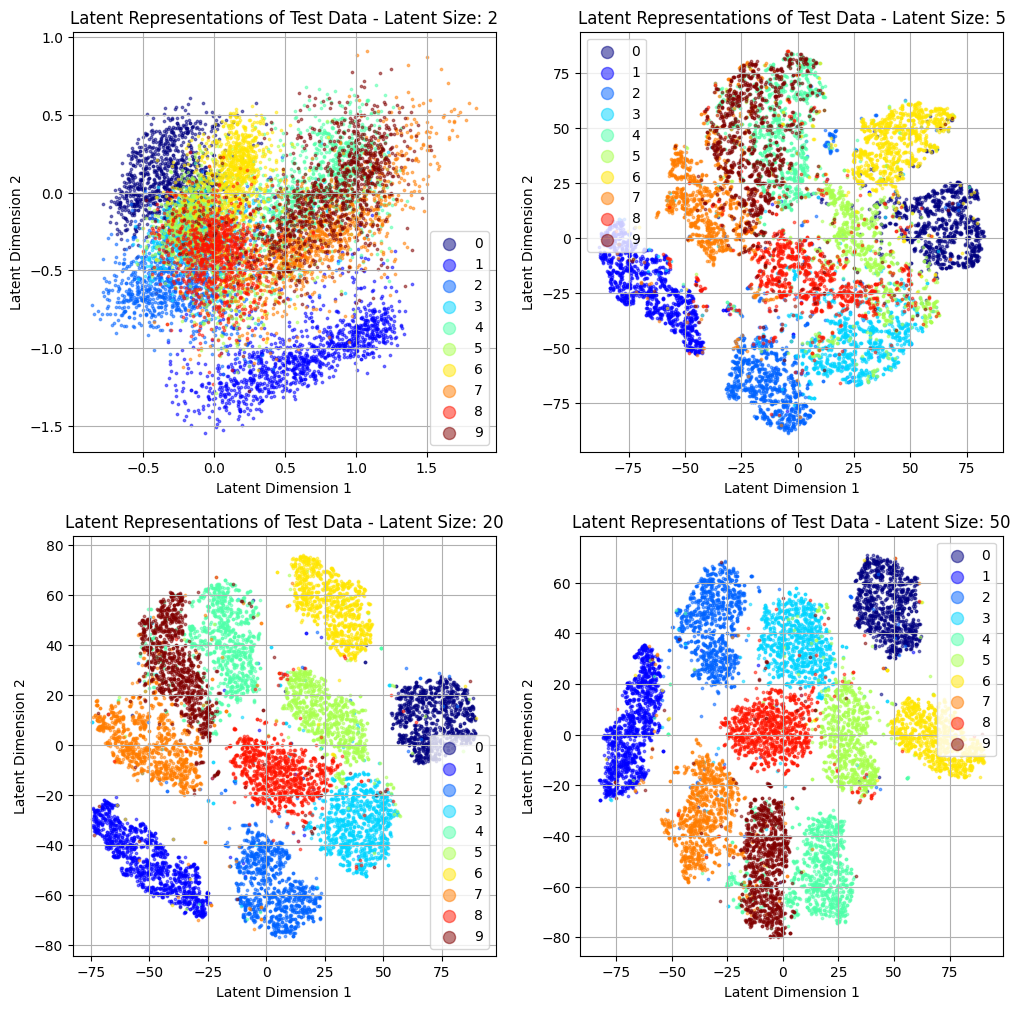

In [23]:
from sklearn.manifold import TSNE

latent_representations_2 = []
latent_representations_5 = []
latent_representations_20 = []
latent_representations_50 = []
labels_agg = []
digits = list(range(10))

mnist_test_ds.start_return_labels()
test_dl_with_labels = DataLoader(mnist_test_ds, batch_size=128)

vae.eval()
vae2.eval()
vae5.eval()
vae20.eval()
vae50.eval()
# Get the latent representations for all test data
with torch.no_grad():
    for images, _, labels in test_dl_with_labels:
        images = images.to(device)
        latent_vectors = vae2.encoder(images)
        latent_representations_2.append(latent_vectors.cpu().numpy())
        latent_vectors = vae5.encoder(images)
        latent_representations_5.append(latent_vectors.cpu().numpy()) 
        latent_vectors = vae20.encoder(images)
        latent_representations_20.append(latent_vectors.cpu().numpy()) 
        latent_vectors = vae50.encoder(images)
        latent_representations_50.append(latent_vectors.cpu().numpy()) 
        labels_agg.append(labels.numpy())

# Concatenate all latent representations
latent_representations_2 = np.concatenate(latent_representations_2, axis=0)
latent_representations_5 = np.concatenate(latent_representations_5, axis=0)
latent_representations_20 = np.concatenate(latent_representations_20, axis=0)
latent_representations_50 = np.concatenate(latent_representations_50, axis=0)
labels_agg = np.concatenate(labels_agg, axis=0)

# Plot the latent representations
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
cmap = plt.get_cmap('jet', 10)
for i, (representation, n_dims) in enumerate(zip([latent_representations_2, latent_representations_5, latent_representations_20, latent_representations_50], [2, 5, 20, 50])):
    # Create a 2D representation of the latent space
    if n_dims == 2:
        X_embedded = representation
    else:
        X_embedded = TSNE(n_components=2).fit_transform(representation)

    # Plot the 2D representation
    ax = axes[i // 2, i % 2]
    for d in digits:
        indices = np.where(labels_agg == d)
        
        ax.scatter(
            X_embedded[indices, 0],
            X_embedded[indices, 1],
            s=3,
            label=f"{d}",
            c=[cmap(d)],
            alpha=0.5,
        )
    ax.legend(markerscale=5)
    ax.set_title(f'Latent Representations of Test Data - Latent Size: {n_dims}')
    ax.set_xlabel('Latent Dimension 1')
    ax.set_ylabel('Latent Dimension 2')
    ax.grid(True)
plt.show()

## Exercício 2

Teste o autoencoder variacional no dataset Fashion MNIST. Compare os resultados obtidos com o dataset MNIST. Teste com diferentes dimensionalidades no espaço latente e tente encontrar a menor dimensionalidade que ainda consegue reconstruir as imagens de forma satisfatória.

<details>
<summary>Dica:</summary>

O autoencoder fornecido talvez seja muito simples para o dataset Fashion MNIST. Tente aumentar a complexidade do modelo.

</details>

In [24]:
faishon_mnist_path = '/pgeoprj2/ciag2024/dados'

In [25]:
class AutoencoderFaishonMNIST(torch.utils.data.Dataset):
    def __init__(self, root, train=True, transform=None, input_transform=None, target_transform=None, download=False, return_labels=False):
        self.dataset = datasets.FashionMNIST(root=root, train=train, transform=transform, download=download)
        self.input_transform = input_transform
        self.target_transform = target_transform
        self.return_labels = return_labels

    def __getitem__(self, idx):
        x, label = self.dataset[idx]
        y = x.clone()

        if self.input_transform:
            x = self.input_transform(x)
        if self.target_transform:
            y = self.target_transform(y)

        return (x, y, label) if self.return_labels else (x, y)
    
    def start_return_labels(self):
        self.return_labels = True
    
    def stop_return_labels(self):
        self.return_labels = False

    def __len__(self):
        return len(self.dataset)

In [26]:
from sklearn.preprocessing import LabelEncoder

class FaishonMnistLabelMapper(object):
    def __init__(self):
        self.mapping = {
            0: 'T-shirt/top',
            1: 'Trouser',
            2: 'Pullover',
            3: 'Dress',
            4: 'Coat',
            5: 'Sandal',
            6: 'Shirt',
            7: 'Sneaker',
            8: 'Bag',
            9: 'Ankle boot'
        }

        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(list(self.mapping.values()))
    
    def __getitem__(self, label):
        return self.mapping[label]
    
    def __call__(self, label):
        return self.label_encoder.inverse_transform([label] if isinstance(label, int) else label)

label_mapper = FaishonMnistLabelMapper()

In [27]:
faishon_mnist_train_ds = AutoencoderFaishonMNIST(
    "./data/fmnist",
    train=True,
    transform=transforms.ToTensor(),
    download=True,
    return_labels=True
)
faishon_mnist_test_ds = AutoencoderFaishonMNIST(
    "./data/fmnist",
    train=False,
    transform=transforms.ToTensor()
)

print(
    "Tamanho do dataset de (treino, teste):", (len(faishon_mnist_train_ds), len(faishon_mnist_test_ds))
)

Failed to download (trying next):
<urlopen error [Errno -2] Name or service not known>



RuntimeError: Error downloading train-images-idx3-ubyte.gz

In [ ]:
# Plot the first 16 images from the MNIST dataset
fig, axes = plt.subplots(4, 4, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    if i == 0:
        print(f"image shape: {faishon_mnist_train_ds[i][0].shape}")
    image, _, label = faishon_mnist_train_ds[i]
    label = label_mapper[label]
    ax.imshow(image.squeeze(), cmap="gray")  # Squeeze removes the channel dimension
    ax.set_title(f"{label}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
fvae_2 = VariationalAutoencoder(latent_size=2, n_channels=1)
fvae_5 = VariationalAutoencoder(latent_size=5, n_channels=1)
fvae_20 = VariationalAutoencoder(latent_size=20, n_channels=1)
fvae_50 = VariationalAutoencoder(latent_size=50, n_channels=1)

In [ ]:
faishon_mnist_train_ds.stop_return_labels()
faishon_mnist_test_ds.stop_return_labels()
faishon_train_dl = DataLoader(faishon_mnist_train_ds, batch_size=128, shuffle=True)
faishon_test_dl = DataLoader(faishon_mnist_test_ds, batch_size=128)

In [ ]:
epochs = 20

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(fvae_2.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(fvae_2, optimizer, criterion, faishon_train_dl, faishon_test_dl, device=device, epochs=epochs)

In [ ]:
epochs = 20

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(fvae_5.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(fvae_5, optimizer, criterion, faishon_train_dl, faishon_test_dl, device=device, epochs=epochs)

In [ ]:
epochs = 20

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(fvae_20.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(fvae_20, optimizer, criterion, faishon_train_dl, faishon_test_dl, device=device, epochs=epochs)

In [ ]:
epochs = 20

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(fvae_50.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(fvae_50, optimizer, criterion, faishon_train_dl, faishon_test_dl, device=device, epochs=epochs)

In [ ]:
# Get some images from the test dataset
data_iter = iter(faishon_test_dl)
images, _ = next(data_iter)

# Move images to the device
images = images.to(device)

# Pass the images through the autoencoder
fvae_2.eval()
fvae_5.eval()
fvae_20.eval()
fvae_50.eval()
with torch.no_grad():
    reconstructions_2 = fvae_2(images)
    reconstructions_5 = fvae_5(images)
    reconstructions_20 = fvae_20(images)
    reconstructions_50 = fvae_50(images)

# Plot the original and reconstructed images
fig, axes = plt.subplots(5, 8, figsize=(12, 8))

for i in range(8):
    ax = axes[0, i]
    ax.imshow(images[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Original Images')

    ax = axes[1, i]
    ax.imshow(reconstructions_2[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Reconstructed Images - Latent Size: 2')

    ax = axes[2, i]
    ax.imshow(reconstructions_5[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Reconstructed Images - Latent Size: 5')

    ax = axes[3, i]
    ax.imshow(reconstructions_20[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Reconstructed Images - Latent Size: 20')

    ax = axes[4, i]
    ax.imshow(reconstructions_50[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Reconstructed Images - Latent Size: 50')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.manifold import TSNE

latent_representations_2 = []
latent_representations_5 = []
latent_representations_20 = []
latent_representations_50 = []
labels_agg = []
classes = list(range(10))

faishon_mnist_test_ds.start_return_labels()
test_dl_with_labels = DataLoader(faishon_mnist_test_ds, batch_size=128)

fvae_2.eval()
fvae_5.eval()
fvae_20.eval()
fvae_50.eval()
# Get the latent representations for all test data
with torch.no_grad():
    for images, _, labels in test_dl_with_labels:
        images = images.to(device)
        latent_vectors = fvae_2.encoder(images)
        latent_representations_2.append(latent_vectors.cpu().numpy())
        latent_vectors = fvae_5.encoder(images)
        latent_representations_5.append(latent_vectors.cpu().numpy()) 
        latent_vectors = fvae_20.encoder(images)
        latent_representations_20.append(latent_vectors.cpu().numpy()) 
        latent_vectors = fvae_50.encoder(images)
        latent_representations_50.append(latent_vectors.cpu().numpy()) 
        labels_agg.append(labels.numpy())

# Concatenate all latent representations
latent_representations_2 = np.concatenate(latent_representations_2, axis=0)
latent_representations_5 = np.concatenate(latent_representations_5, axis=0)
latent_representations_20 = np.concatenate(latent_representations_20, axis=0)
latent_representations_50 = np.concatenate(latent_representations_50, axis=0)
labels_agg = np.concatenate(labels_agg, axis=0)

# Plot the latent representations
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
cmap = plt.get_cmap('jet', 10)
for i, (representation, n_dims) in enumerate(zip([latent_representations_2, latent_representations_5, latent_representations_20, latent_representations_50], [2, 5, 20, 50])):
    # Create a 2D representation of the latent space
    if n_dims == 2:
        X_embedded = representation
    else:
        X_embedded = TSNE(n_components=2).fit_transform(representation)

    # Plot the 2D representation
    ax = axes[i // 2, i % 2]
    for c in classes:
        indices = np.where(labels_agg == c)
        
        ax.scatter(
            X_embedded[indices, 0],
            X_embedded[indices, 1],
            s=3,
            label=f"{label_mapper[c]}",
            c=[cmap(c)],
            alpha=0.5,
        )
    ax.legend(markerscale=5)
    ax.set_title(f'Latent Representations of Test Data - Latent Size: {n_dims}')
    ax.set_xlabel('Latent Dimension 1')
    ax.set_ylabel('Latent Dimension 2')
    ax.grid(True)
plt.show()